In [51]:
import csv
import os
from datetime import datetime
import math
import matplotlib.pyplot as plt

In [52]:
options_dir = '../data/options_data'
for ticker in os.listdir(options_dir):
    ticker_dir = options_dir + '/' + ticker
    call_files = []
    put_files = []
    for file in os.listdir(ticker_dir):
        file_heruistics = file.split('_')
        strike = file_heruistics[2].split('-', 1)
        expiry_date = datetime.strptime(file_heruistics[1], '%Y%m%d').date()

        if 'c' in strike[0].replace('.csv', ''):
            call_files.append((file, expiry_date))
        if 'p' in strike[0].replace('.csv', ''):
            put_files.append((file, expiry_date))

    call_files.sort(key=lambda contract: contract[1])
    put_files.sort(key=lambda contract: contract[1])

    #implement synthetic long strategy
    balance = 100000
    
    callContracts = 0
    putContracts = 0
    csv_data = []
    c_csv_data = []
    p_csv_data = []
    smaller = call_files
    
    if(len(call_files) > len(put_files)):
        smaller = put_files
    for x in range(len(smaller)):

        cfile, c_expiry_date = call_files[x]
        pfile, p_expiry_date = put_files[x]

        with open(os.path.join(ticker_dir, cfile), 'r') as f:
            #CALL LOGIC: BUY AT BEGINNING OF EACH MONTH
            strike_csv = csv.reader(f)
            row = list(strike_csv)

            for index, line in reversed(list(enumerate(row[0:len(row)-1]))):
                date = datetime.strptime(line[0], '%m/%d/%Y').date()
                if date.month == c_expiry_date.month:
                    c_start_open = float(row[index][1])
                    c_strike_price = float(row[index][16])
                    c_start_price = float(row[index][15])
                    c_end_price = float(row[1][15])
                    break

            # buy call contracts + subtract balance
            
            callContracts = math.floor((balance*.75)/(c_start_open * 100))
            balance -= (c_start_open * 100) * callContracts
            
        with open(os.path.join(ticker_dir, pfile), 'r') as f:
            #PUT LOGIC: SELL AT BEGINNING OF EACH MONTH
            strike_csv = csv.reader(f)
            row = list(strike_csv)

            for index, line in reversed(list(enumerate(row[0:len(row)-1]))):
                date = datetime.strptime(line[0], '%m/%d/%Y').date()
                if date.month == p_expiry_date.month:
                    p_start_open = float(row[index][1])
                    p_strike_price = float(row[index][16])
                    p_start_price = float(row[index][15])
                    p_end_price = float(row[1][15])
                    break

            # sell put contracts + add balance
            
            putContracts = math.floor((balance*.75)/(p_start_open * 100))
            balance += (p_start_open * 100) * putContracts

        
        # compare end asset price to strike price
        if c_end_price >= c_strike_price:
            #Call expires in the money we gain difference between strike and actual price times contracts times 100
            stockSale = (callContracts * 100) * (c_end_price - c_strike_price)
            balance += stockSale
            profits = stockSale
            
        else:
            #Put expires in the money we lose difference between strike and actual price times contracts times 100
            #If put expires ITM we must buy back 100 shares times contracts
            stockPurchase = (putContracts * 100) * (p_strike_price - p_end_price)
            balance -= stockPurchase
            profits = stockPurchase * -1
            
            
        total_balance = balance

        # obtain 'results'
        net_percentage = ((total_balance - 100000) / 100000) * 100
        net_return = total_balance - 100000

        #c_csv_data.append(['Call',c_expiry_date, date, c_strike_price, c_start_price, c_end_price, c_start_open, callContracts, profits,total_balance, net_percentage, net_return])
        #p_csv_data.append(['Put',p_expiry_date, date, p_strike_price, p_start_price, p_end_price, p_start_open, putContracts, profits,total_balance, net_percentage, net_return])
        csv_data.append([p_expiry_date, date, p_strike_price, p_start_price, p_end_price, p_start_open, putContracts, profits,total_balance, net_percentage, net_return])

    with open('../data/outputs/synthetic_long/' + ticker + '.csv', 'w', newline="") as f:
        writer = csv.writer(f)

        header = ['Expiration Date', 'Date Position Opened', 'Strike Price', 'Starting asset price', 'Ending Asset Price', 'Price Per Contract', 'Contracts', 'Contract Profit/Loss', 'Monthly Ending Balance', 'Percent Change', 'Profit Amount']
        writer.writerow(header)

        for row in csv_data:
            writer.writerow(row)
            #writer.writerow(c_csv_data[x])
            #writer.writerow(p_csv_data[x])

x-axis values: ['10/2019', '11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [220332.0, 703184.0, 2814327.0, 875472.0, 214396.0, 144800.0, 294258.0, 352323.0, 58786.0, 454291.0, 763096.0, -33411.0, -5412.0, -14006.0, -9300.0, -1866.0, -677.0, 173.0, 173.0, 173.0, 173.0, 173.0, 173.0, 173.0, 173.0]


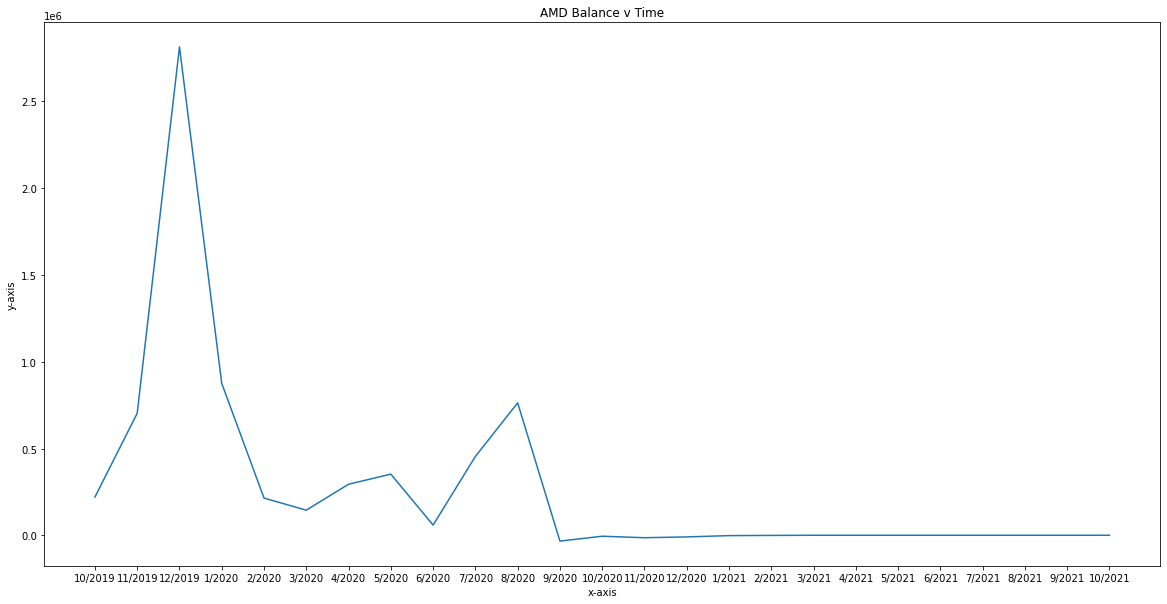

x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [40979.0, 84981.0, 64763.0, -10163.0, 10529.0, 7375.0, 2741.0, 4600.0, 6131.0, 5003.0, 8551.0, 26457.0, 56289.0, 22519.0, 103231.0, 147989.0, 278949.0, 205001.0, 743949.0, 251052.0, -2925.0, 483.0, 794.0, 2514.0]


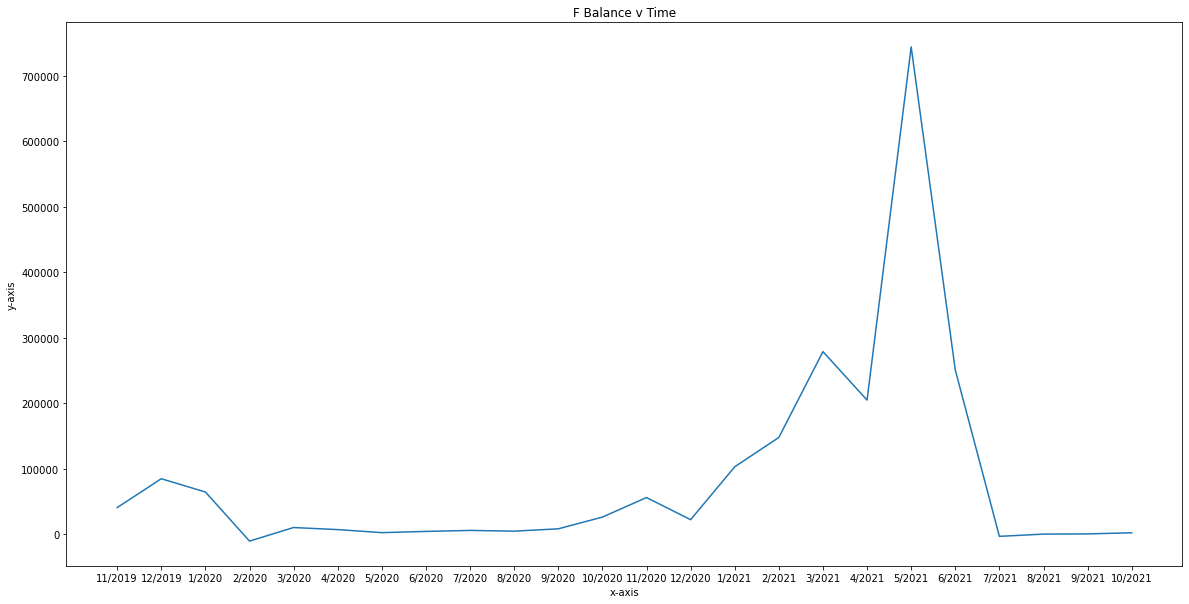

x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [39626.0, 87326.0, 11903.0, 14463.0, -17321.0, -32221.0, -26199.0, -20271.0, -8406.0, -25426.0, -44011.0, -122878.0, -444272.0, 3331.0, 7379.0, 4509.0, 14625.0, 10677.0, 3785.0, 1137.0, 64.0, 64.0, 64.0, 64.0]


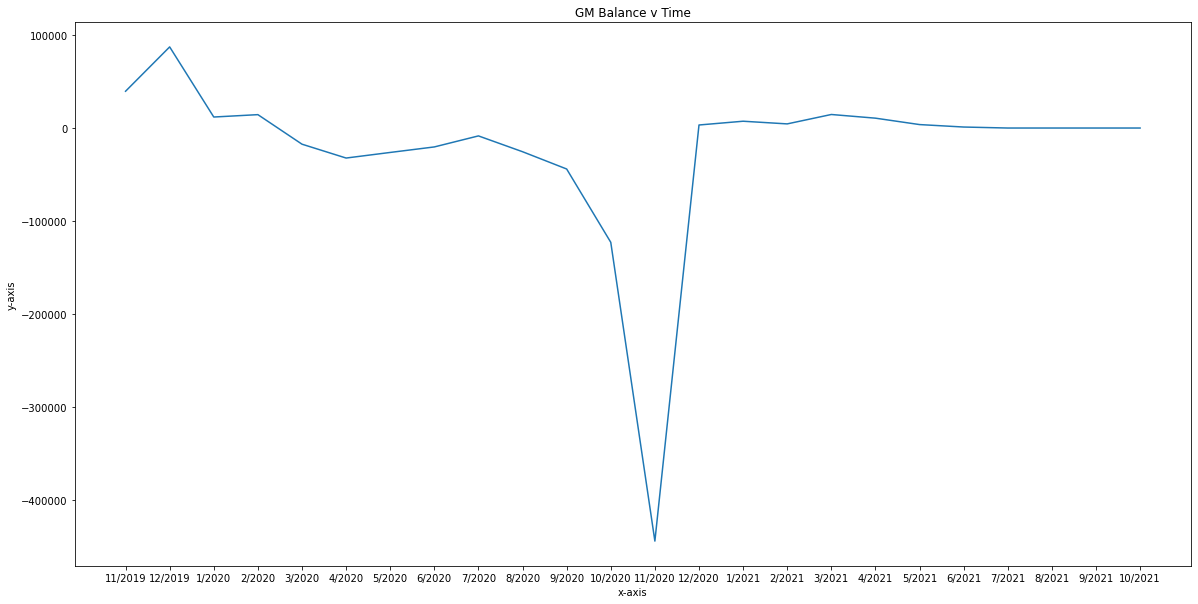

x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [214366.0, 488151.0, 1064255.0, 92945.0, 10145.0, 27062.0, 39192.0, 100954.0, 85734.0, 237888.0, 17265.0, 4230.0, 6177.0, 9147.0, 21129.0, 5680.0, 4125.0, 7381.0, 3695.0, 8919.0, 19294.0, 51282.0, 20712.0, 134205.0]


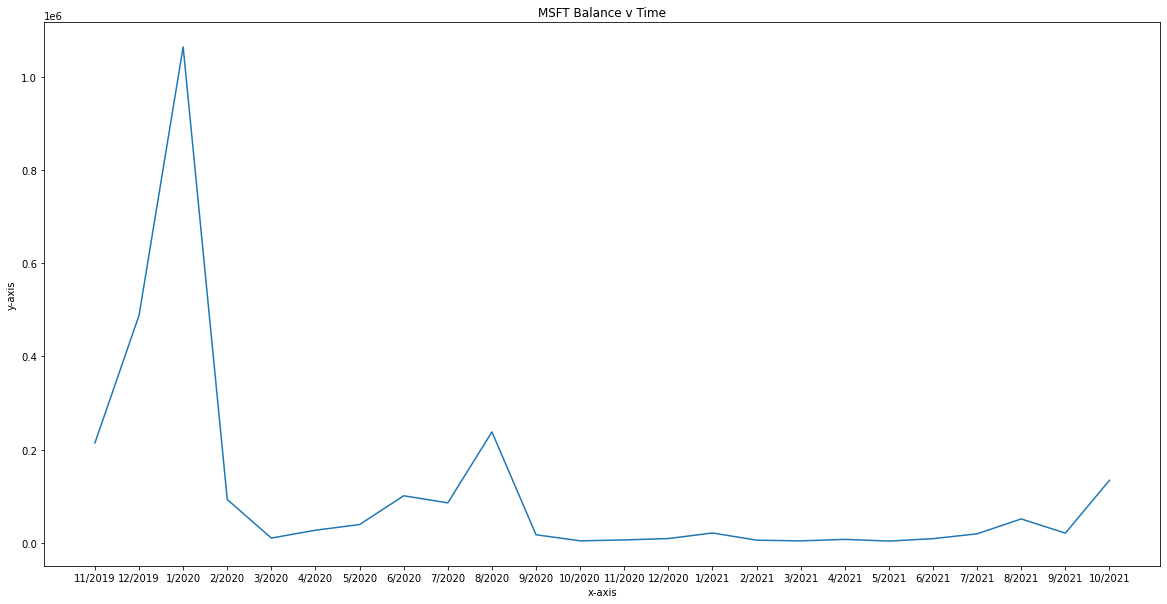

In [53]:
# graph results using matlab pyplot

outputs = '../data/outputs/synthetic_long/'
files = [f for f in os.listdir(outputs) if os.path.isfile(os.path.join(outputs, f))]

for file in files:
    with open(os.path.join(outputs, file), 'r') as f:
        output_csv = csv.reader(f)
        rows = list(output_csv)
        
        profits = []
        monthly_balance = []
        months = []

        for line in rows[1:]:
            profits.append(round(float(line[10]), 2))
            monthly_balance.append(round(float(line[8]),2))
            date = datetime.strptime(line[0], "%Y-%m-%d").date()
            months.append(str(date.month) + '/' + str(date.year))
        
        print('x-axis values: ' + str(months))
        print('y-axis values: ' + str(monthly_balance))

        x1 = months
        y1 = monthly_balance

        return_plt = plt.figure()
        return_plt.set_figheight(10)
        return_plt.set_figwidth(20)
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.title(file.replace('.csv', '') + ' Balance v Time')
        plt.plot(x1, y1)
        plt.savefig('../data/outputs/synthetic_long/graphs/' + file.replace('.csv', '') + '_balance_v_time.jpg')
        plt.show()
        
